# Randoms

In this notebook I attepted many times to create an uniform random sky distributed catalog. After Jim suggestion of using the unit sphere as a reference I finally succseed. \
https://stackoverflow.com/questions/33976911/generate-a-random-sample-of-points-distributed-on-the-surface-of-a-unit-sphere \
https://stats.stackexchange.com/questions/7977/how-to-generate-uniformly-distributed-points-on-the-surface-of-the-3-d-unit-sphe 


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from nbodykit.lab import *
from nbodykit import setup_logging, style

from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
plt.style.use(style.notebook)

In [3]:
#!/usr/bin/env python
import os, fitsio

import sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.io.fits import getdata
from astropy.table import Table
from scipy.interpolate import interp1d

In [4]:
import matplotlib
matplotlib.rc('xtick', labelsize=20, top=True, direction='in')
matplotlib.rc('ytick', labelsize=20, right=True, direction='in')
matplotlib.rc('axes', linewidth=1, labelsize=20)
matplotlib.rc('xtick.major', size=5)
#matplotlib.rc('xtick.minor', size=5)
matplotlib.rc('ytick.major', size=5)
#matplotlib.rc('ytick.minor', size=5)

In [5]:
from astropy.cosmology import FlatLambdaCDM
cosmo0 = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
cosmo0 

FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=2.725 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=None)

In [6]:
import skymapper as skm

def plot_proj(ra, dec, labels, Npoints=10000,title='DES K-Means'):
    idx = np.random.randint(len(ra), size=Npoints)
    # define the best Albers projection for the footprint
    # minimizing the variation in distortion
    crit = skm.stdDistortion
    proj = skm.WagnerIV.optimize(ra[idx], dec[idx], crit=crit)

    # construct map: will hold figure and projection
    # the outline of the sphere can be styled with kwargs for matplotlib Polygon
    map = skm.Map(proj)

    # add graticules, separated by 15 deg
    # the lines can be styled with kwargs for matplotlib Line2D
    # additional arguments for formatting the graticule labels
    sep=15
    map.grid(sep=sep)

    # add scatter plot
    map.scatter(ra[idx], dec[idx], c=labels[idx], cmap='rainbow', s=25, alpha=0.8,  edgecolor='w', facecolor='None')


    # # focus on relevant region
    #map.focus(ra[idx], dec[idx], pad=0.1)

    map.title(title)
    
    # hide x-ticks
    ax = map.ax
    labels = [item.get_text() for item in ax.get_xticklabels()]
    
    map.footprint(skm.survey.DES(), 64, cmap='RdYlBu_r')
    #empty_string_labels = ['']*len(labels)
    #ax.set_xticklabels(empty_string_labels)
    

In [7]:
kw = {'dS':r'$\Delta \Sigma \, \, [M_{\odot}]$',
      'gamma': r'$\left< \gamma_t(\theta) \right>$'}


## Load Mock

In [8]:
from fileLoc import FileLocs

floc = FileLocs(machine='nersc')
print('halo file name: %s'%floc.mock_fname)

mock = Table(getdata(floc.mock_fname))

halo file name: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/mock_buzzard_like_y3_v0.fits


In [9]:
data = Table(mock[['RA','DEC','redshift']])
data.rename_columns(['RA','DEC','redshift'], ['ra','dec','z'])
select_good = (data['z']>=0.2) & (data['z']<=0.65)
select_good = select_good & ((data['z'] < 0.33)|(data['z'] > 0.37))

ra = data['ra']
ix, = np.where(ra<0); ra[ix] = ra[ix]+360
data['ra'] = ra

data = data[select_good]

### Mock Healpix Map

In [10]:
def radec_to_pix(ra,dec,nside=4):
    thetas,phis = np.radians(90-dec),np.radians(ra)
    return hp.ang2pix(nside, thetas, phis,nest=False)

In [11]:
import healpy as hp

Nside = 64
npix = hp.nside2npix(Nside)
hpx_mock = np.array(radec_to_pix(data['ra'],data['dec'],nside=Nside))

hpxmap = np.zeros(npix, dtype=np.int)
w, values = np.unique(hpx_mock,return_counts=True)
hpxVals = hpxmap.copy()
hpxVals[w] = values
hpxmap[w] = 1
hpxmap[hpxmap==hp.UNSEEN] = 0

/global/homes/j/jesteves/.conda/envs/nbodykit-env/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


Text(0.5, 1.0, 'Mock: Buzzard Y3 Footprint')

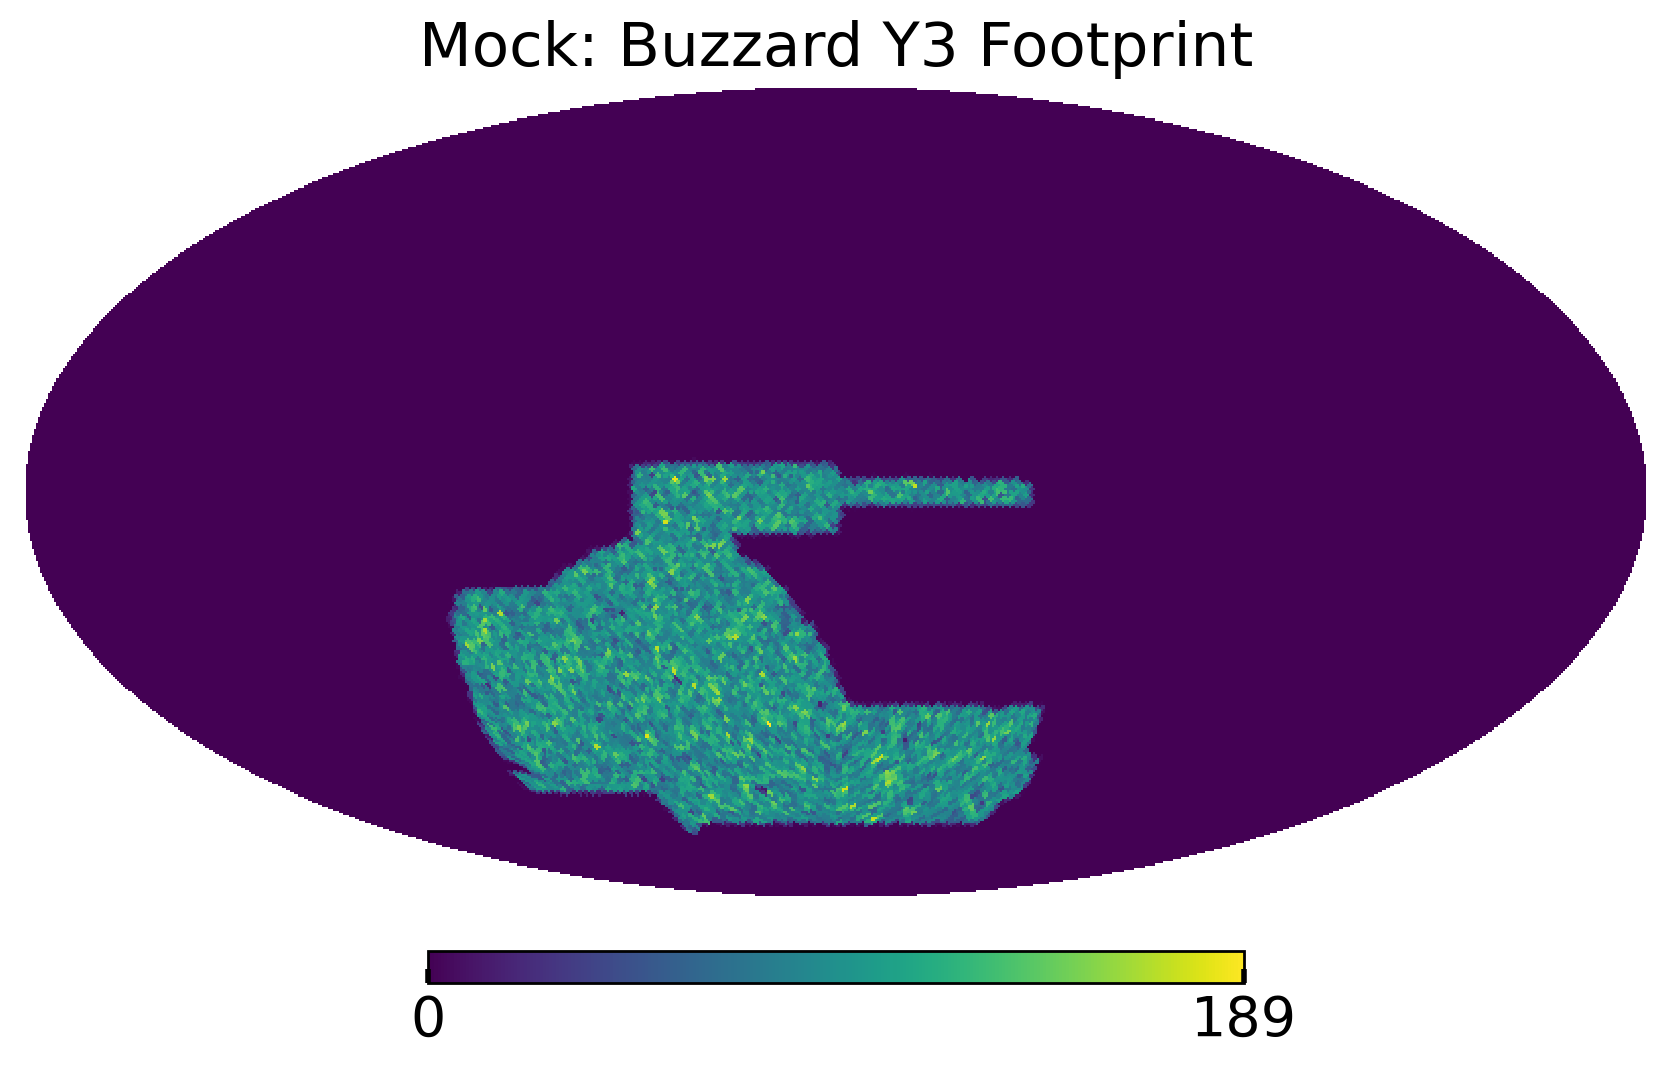

In [12]:
hp.mollview(hpxVals)
plt.title('Mock: Buzzard Y3 Footprint')

# Produces Randoms

1. Make an uniform distribution in cartesian space.
2. Project into the Unit Sphere
3. Cutout the random sky distribution to the DES Y3 footprint.

In [365]:
def combine_boxes(source):
    s1 = source.copy()
    s2 = source.copy()
    s3 = source.copy()
    s4 = source.copy()
    s5 = source.copy()
    
    # make four squares
    # -ra, dec
    s2['ra'] *= -1.
    # ra, -dec
    s3['dec']*= -1.
    # -ra, -dec
    s4['ra'] *= -1.
    s4['dec'] *= -1.
    
    s5['ra'] += 90
    s5['dec']*=-1.
    combined = transform.ConcatenateSources(s1, s2, s3, s4, s5, columns=['ra','dec'])
    labels = np.hstack([np.ones(s1.csize), 2*np.ones(s1.csize), 3*np.ones(s1.csize), 4*np.ones(s1.csize), 5*np.ones(s5.size)])
    
    return combined, labels
    

In [514]:
from nbodykit.transform import CartesianToSky, CartesianToEquatorial
from nbodykit.lab import UniformCatalog
cosmo = cosmology.Cosmology(h=0.7).match(Omega0_m=0.3)

source = UniformCatalog(nbar=100, BoxSize=20.0)
_posSky = CartesianToEquatorial(source['Position'], observer=[0., 0., 0], frame='icrs')
# _posSky = CartesianToSky(source['Position'], cosmo, source['Velocity'])

source['ra'] = np.where(_posSky[0]<0, _posSky[0]+360, _posSky[0])
source['dec'] = _posSky[1]

In [515]:
np.max(np.array(source['Position']),axis=0)

array([19.99988506, 19.99999018, 19.99997923])

In [51]:
def makeHealpixMap(ra, dec, nside=1024, nest=False):
    # convert a ra/dec catalog into healpix map with counts per cell
    import healpy as hp
    ipix = hp.ang2pix(nside, (90-dec)/180*np.pi, ra/180*np.pi, nest=nest)
    return np.bincount(ipix, minlength=hp.nside2npix(nside))

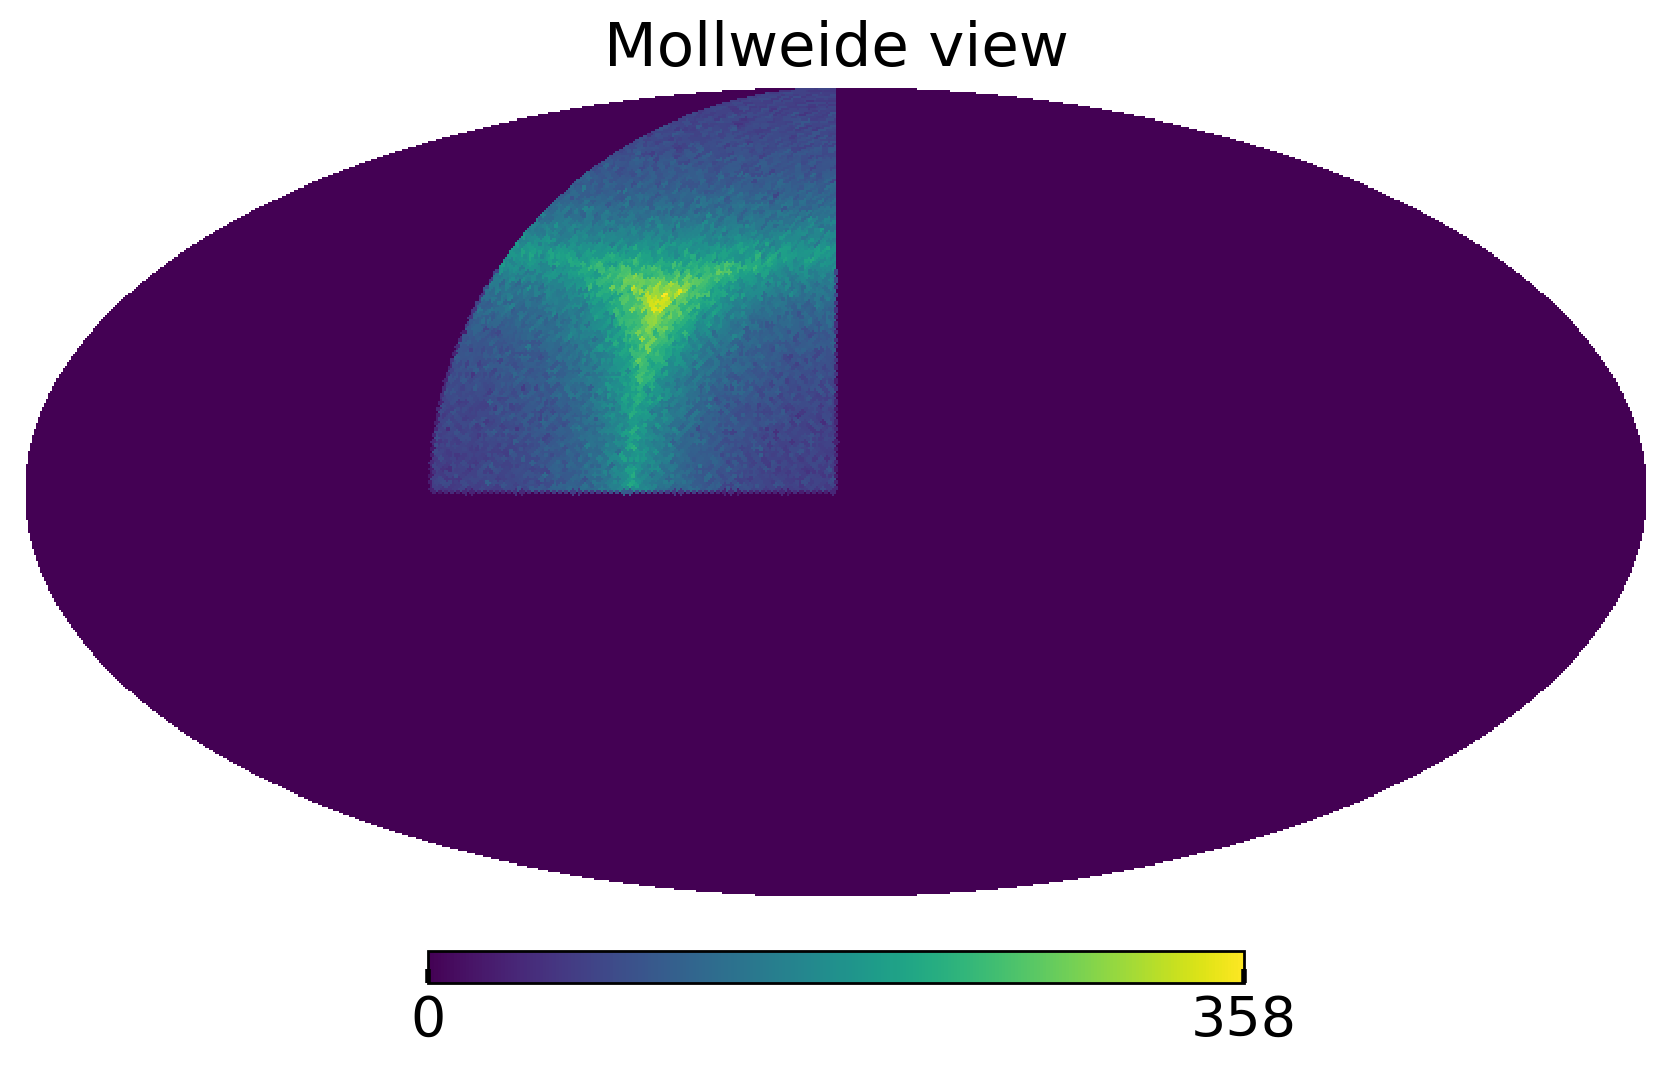

In [517]:
hm = makeHealpixMap(np.array(source['ra']), np.array(source['dec']),nside=64)
hp.mollview(hm)

In [518]:
# combine boxes on th sky
combined,labels = combine_boxes(source)

optimizing parameters of WagnerIV to minimize stdDistortion
best objective 0.153183 at WagnerIV(27.204602840295852)


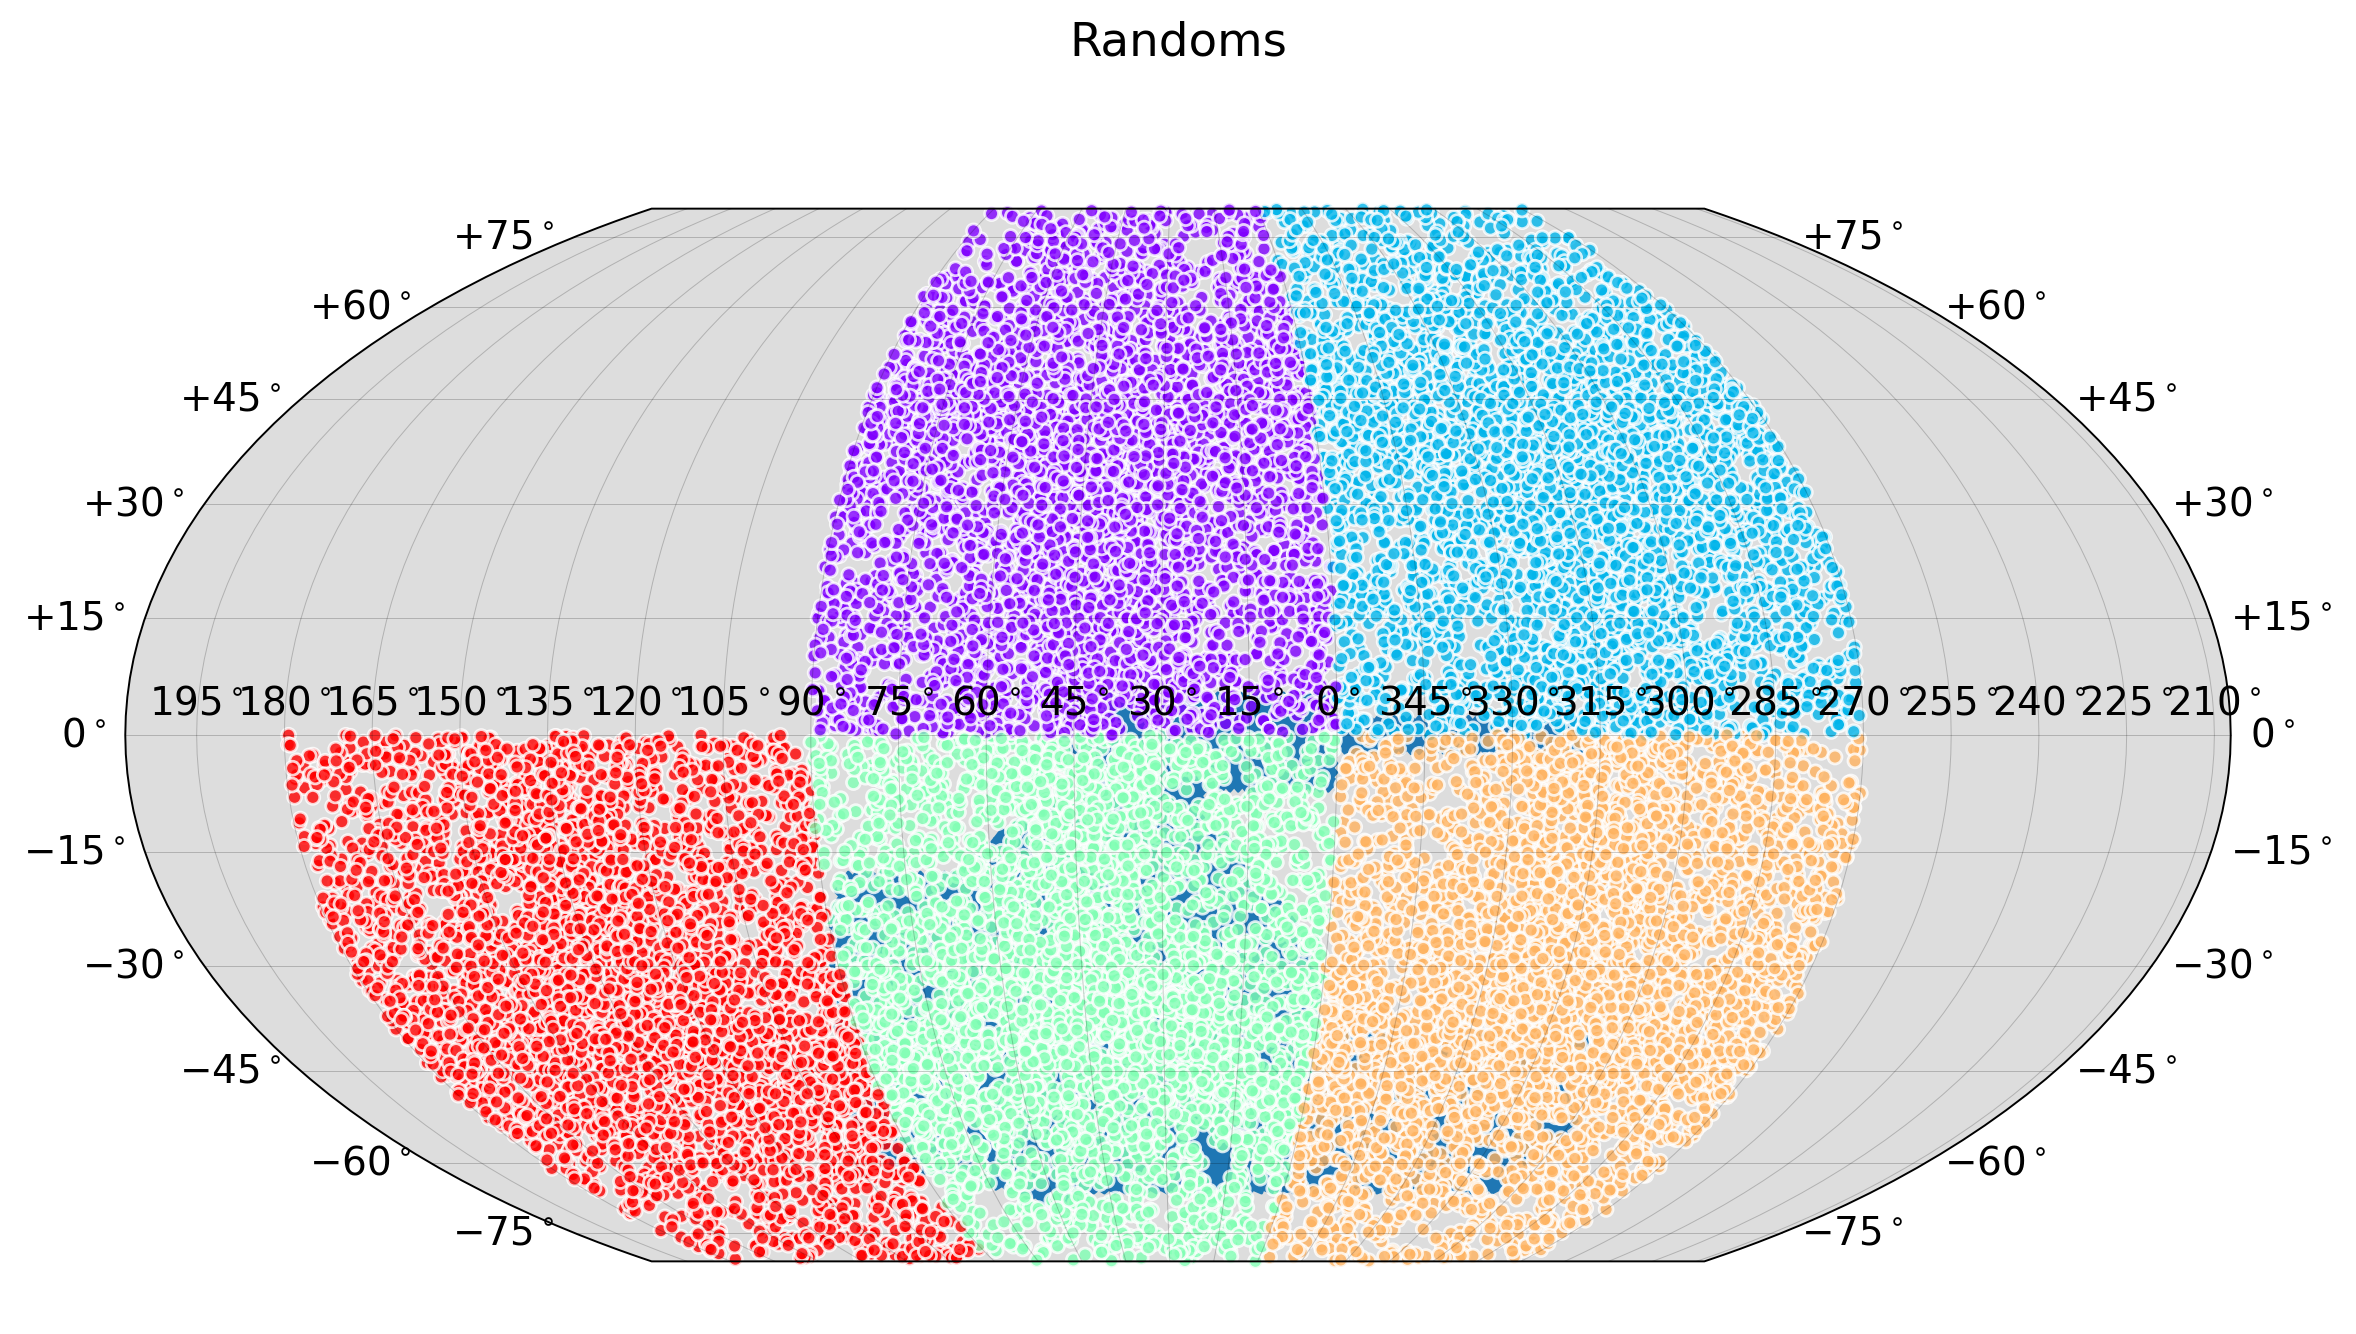

In [519]:
plot_proj(np.array(combined['ra']), np.array(combined['dec']), labels, title='Randoms', Npoints=int(2e4))

### Cut for the Mock Footprint

In [418]:
hpx_coords = radec_to_pix(np.array(combined['ra']), np.array(combined['dec']),nside=64)
ran_mask = hpxmap[hpx_coords].astype(bool)
combined['hpx_mask'] = ran_mask

randoms = combined[combined['hpx_mask']].copy()

optimizing parameters of Albers to minimize stdDistortion
best objective 0.045282 at Albers(22.912386311186964,-37.988858565073826,-56.9471034332148,-11.98826939444398)


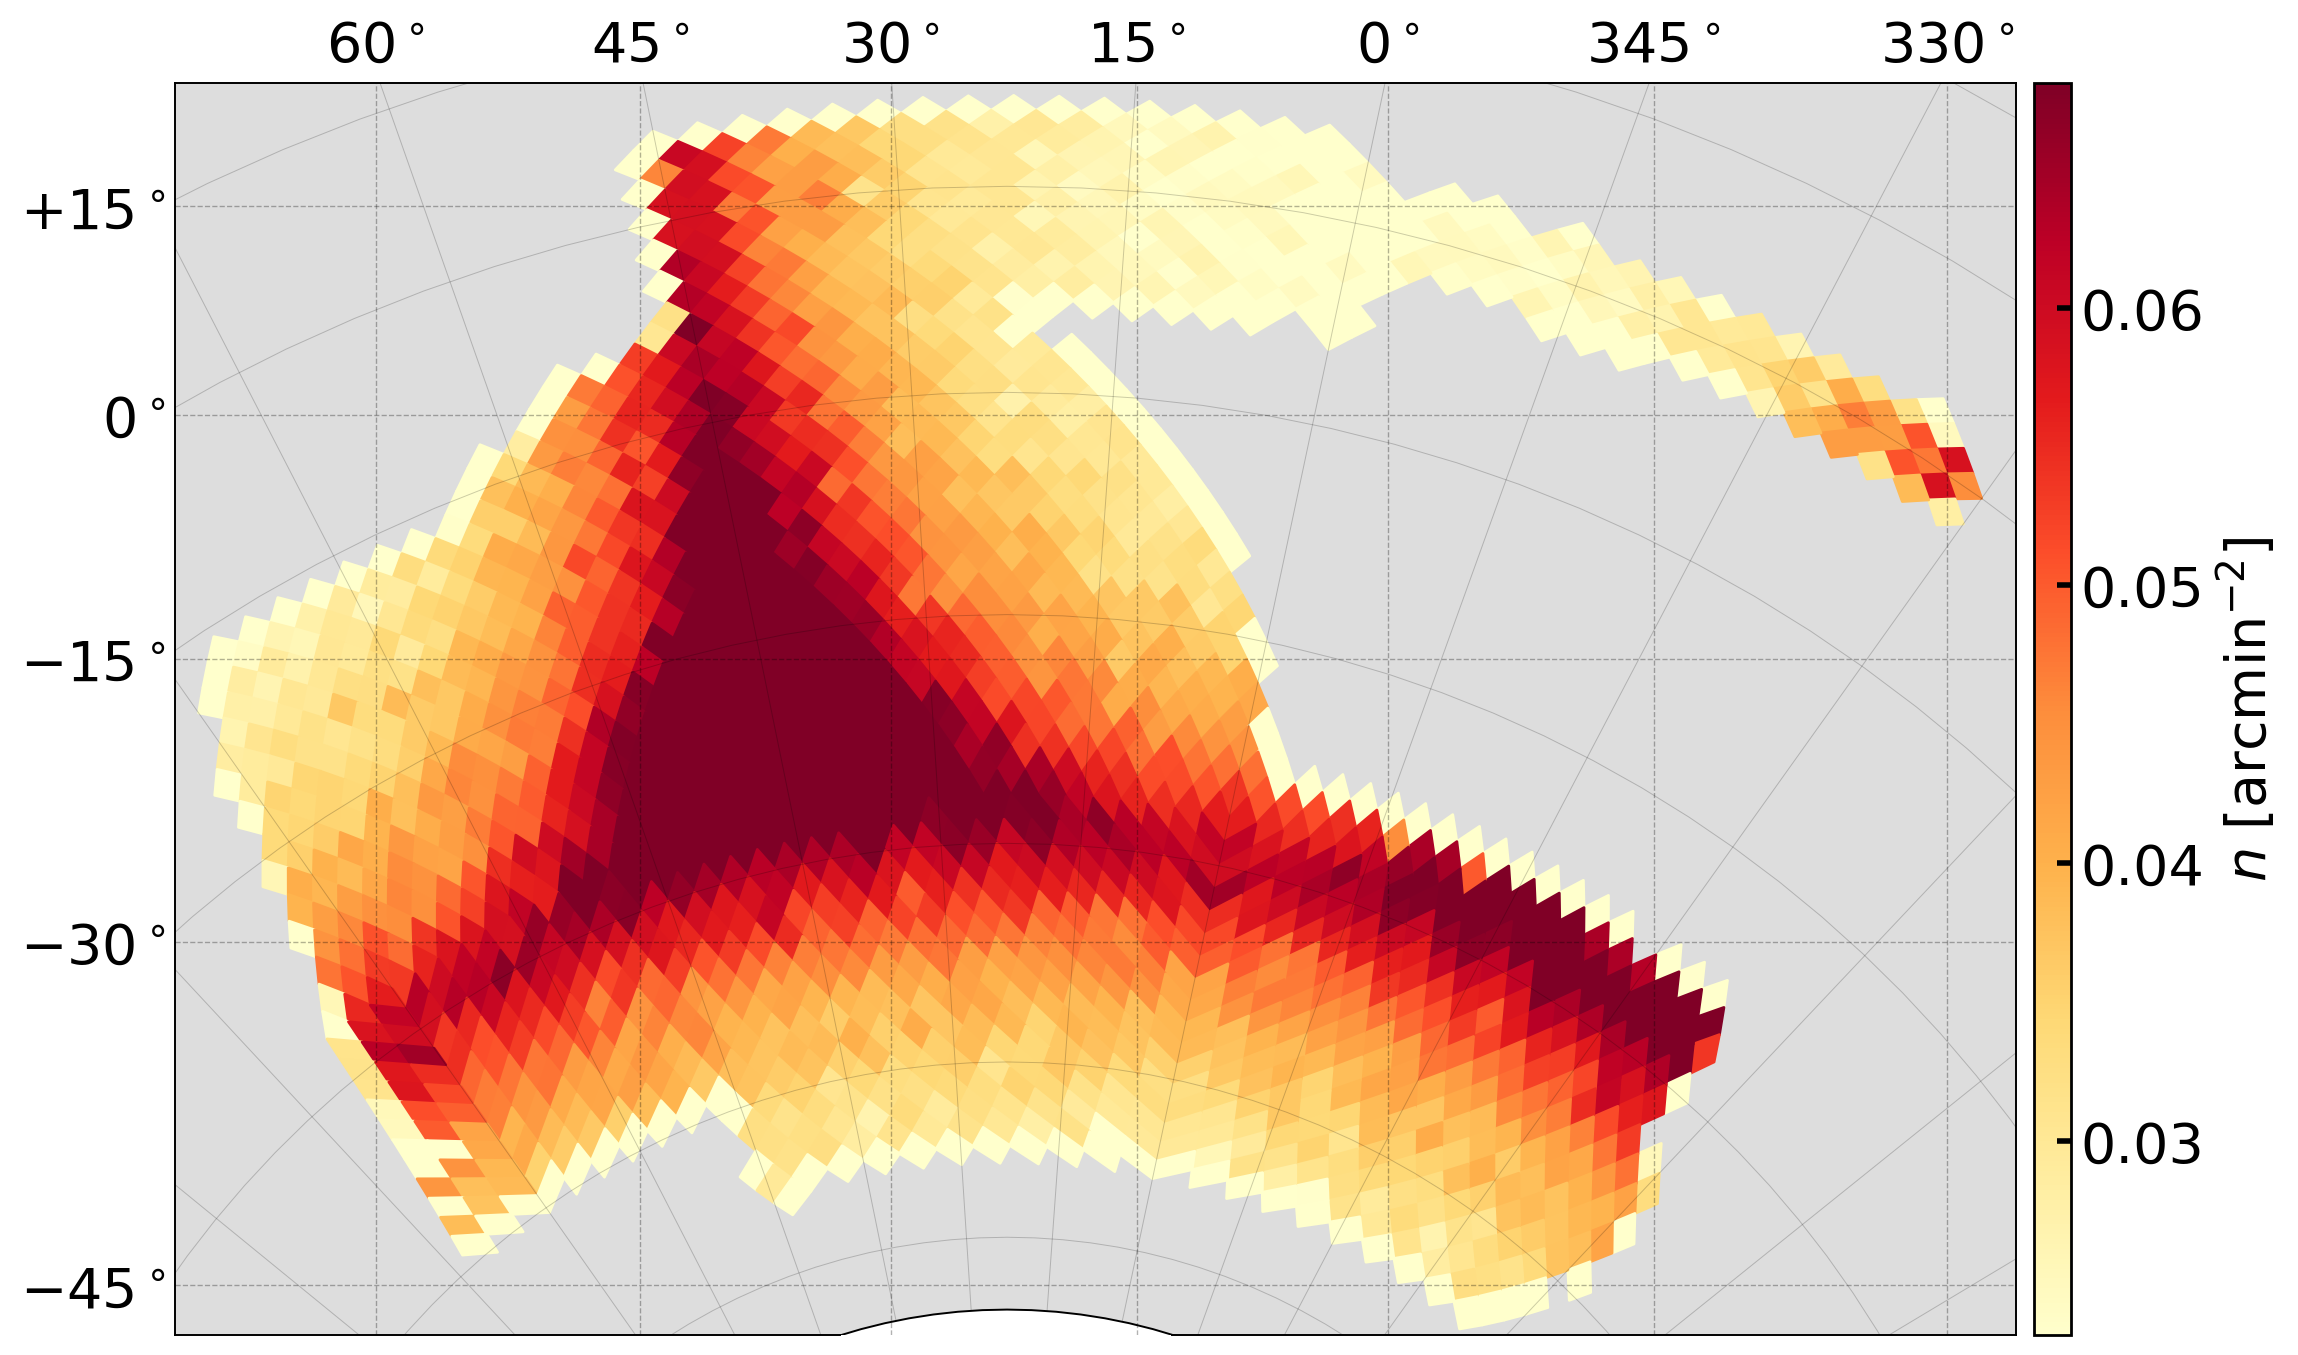

In [419]:
plot_hpx_density(np.array(randoms['ra']), np.array(randoms['dec']))


optimizing parameters of Albers to minimize stdDistortion
best objective 0.047151 at Albers(25.09576457680782,-35.285259392438086,-57.30484915964707,-11.1899380656554)


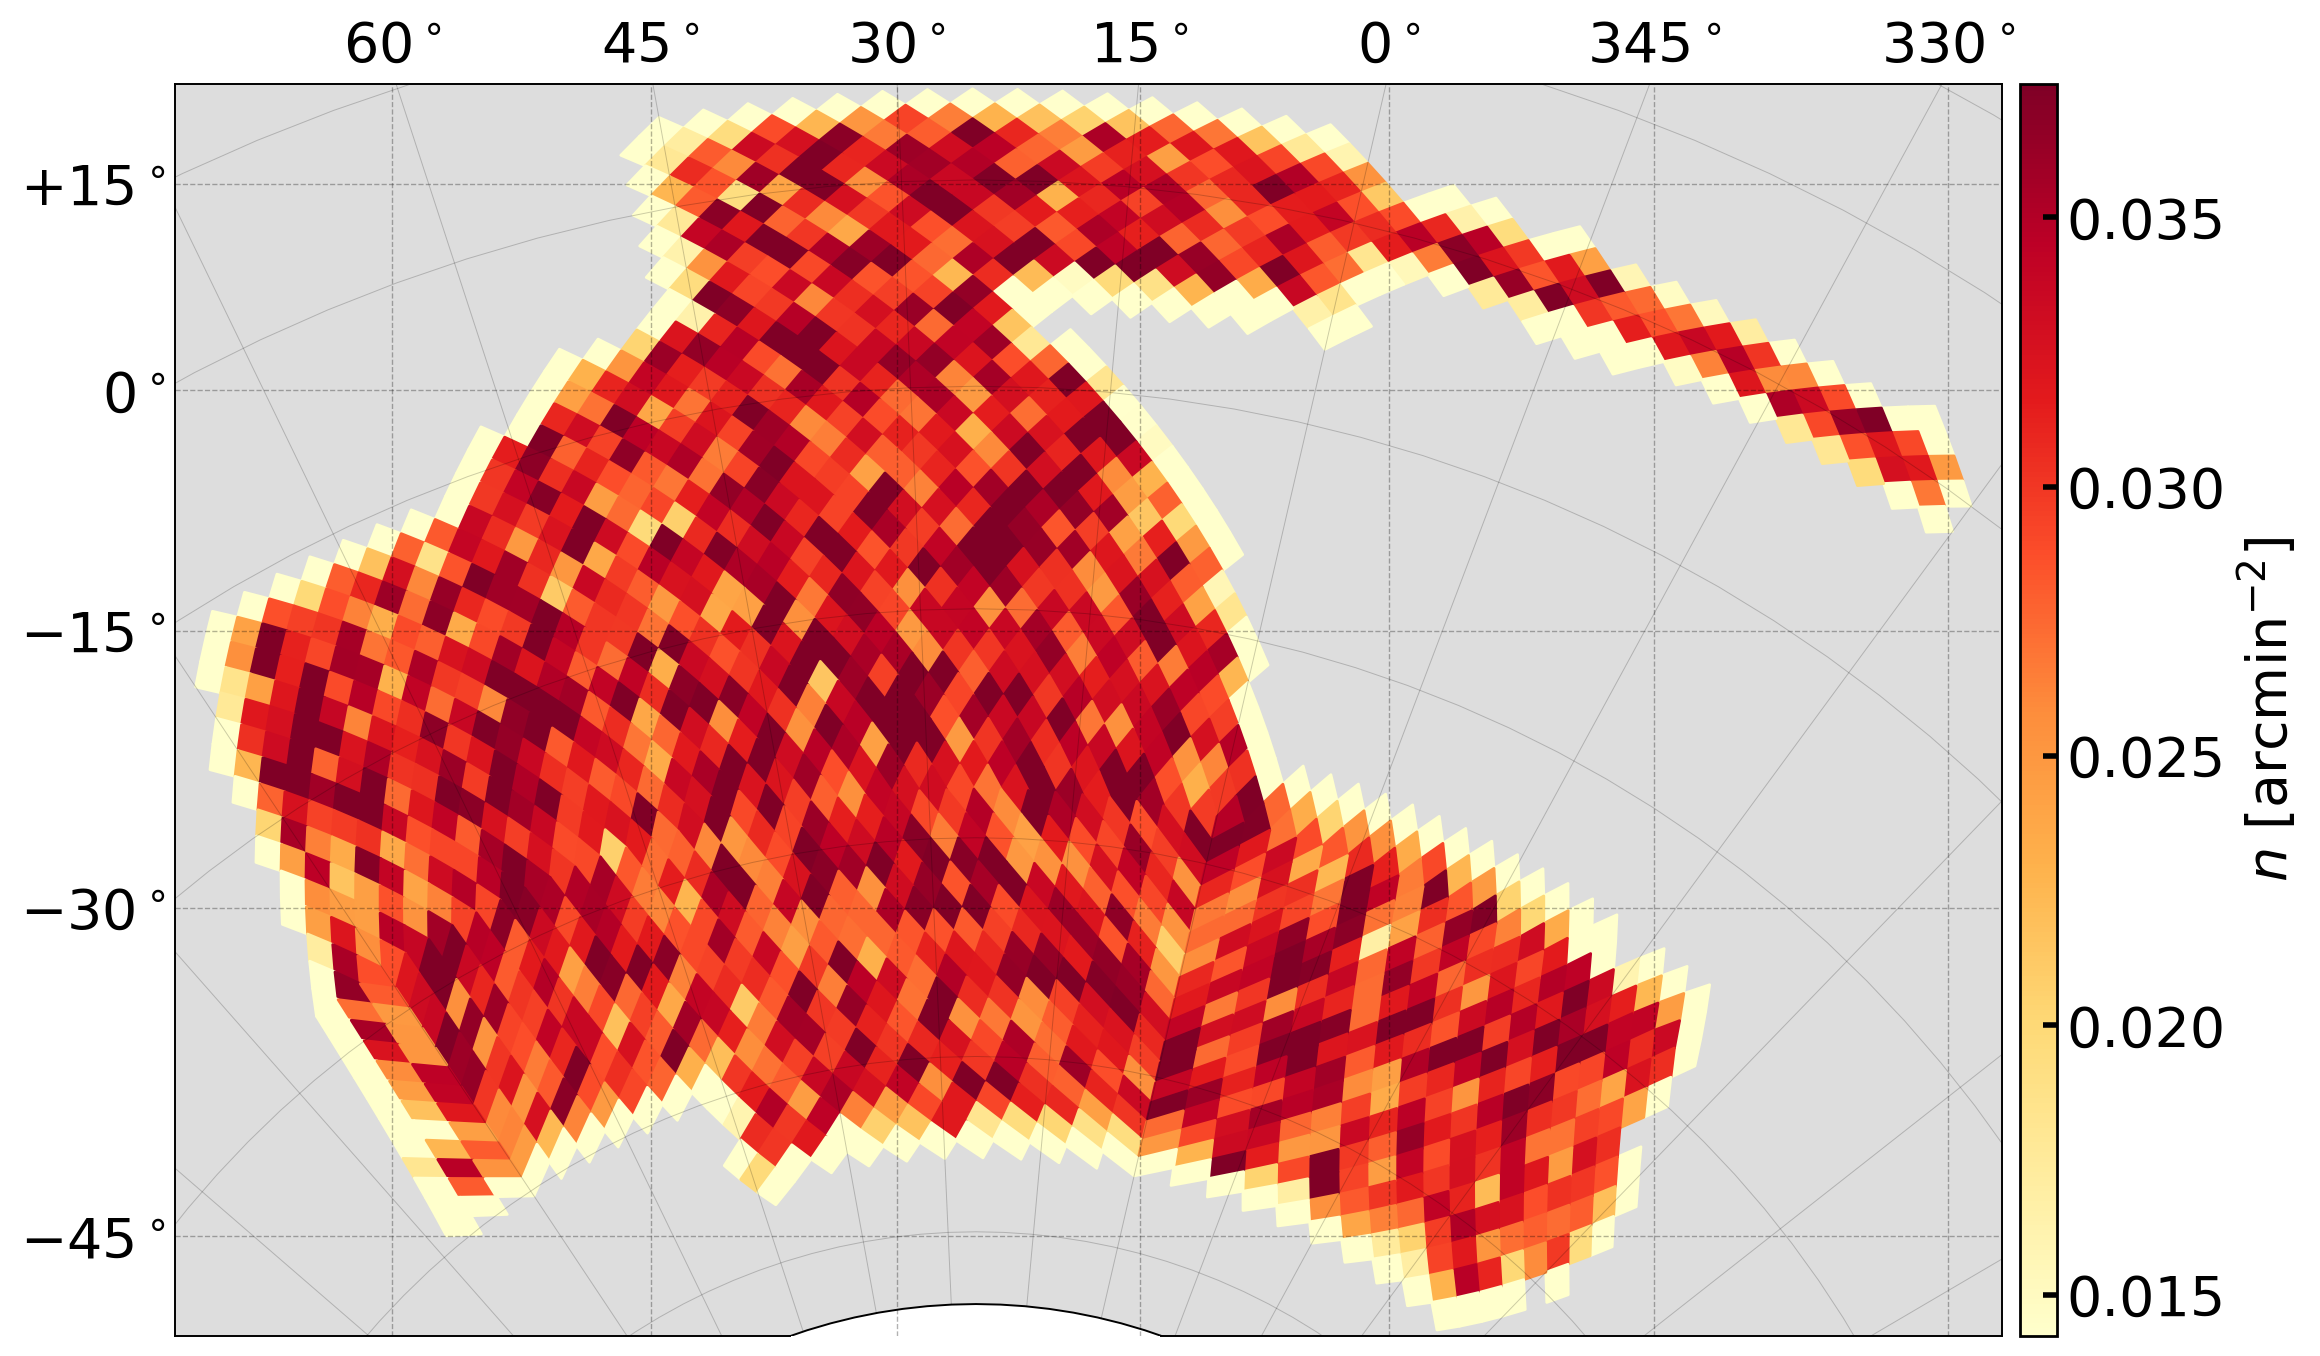

In [421]:
plot_hpx_density(np.array(data['ra']), np.array(data['dec']))


## Unit Shpere

In [84]:
import numpy as np

def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

Npoints = int(5e6)
phi = np.linspace(0, np.pi, 20)
theta = np.linspace(0, 2 * np.pi, 40)
x = np.outer(np.sin(theta), np.cos(phi))
y = np.outer(np.sin(theta), np.sin(phi))
z = np.outer(np.cos(theta), np.ones_like(phi))

xi, yi, zi = sample_spherical(Npoints)
pos = np.vstack([xi,yi,zi]).T

In [85]:
# Nsize = 500
# Nbox = Nsize**3
# # good
# # Lsize = 10
# Lsize = 1.
# _x = np.random.uniform(-Lsize, Lsize, size=int(Nsize))
# _y = np.random.uniform(-Lsize, Lsize, size=int(Nsize))
# _z = np.random.uniform(-Lsize, Lsize, size=int(Nsize))

# #rad_size = np.sqrt(_x**2+_y**2+_z**2)
# rad_size = np.sqrt(3)
# posx,posy,posz = np.meshgrid(_x/rad_size,_y/rad_size,_z/rad_size)
# pos = np.vstack([posx.flatten(), posy.flatten(),posz.flatten()]).T

In [86]:
randoms = RandomCatalog(pos.shape[0], seed=42)
randoms['Position'] = randoms.make_column(pos)
randoms['Position']

dask.array<array, shape=(5000000, 3), dtype=float64, chunksize=(100000, 3), chunktype=numpy.ndarray>

In [87]:
from nbodykit.transform import CartesianToSky, CartesianToEquatorial

_posSky = CartesianToEquatorial(randoms['Position'],observer=[0., 0., 0.], frame='icrs')
randoms['ra'] = np.where(_posSky[0]<0, _posSky[0]+360, _posSky[0])
randoms['dec'] = _posSky[1]

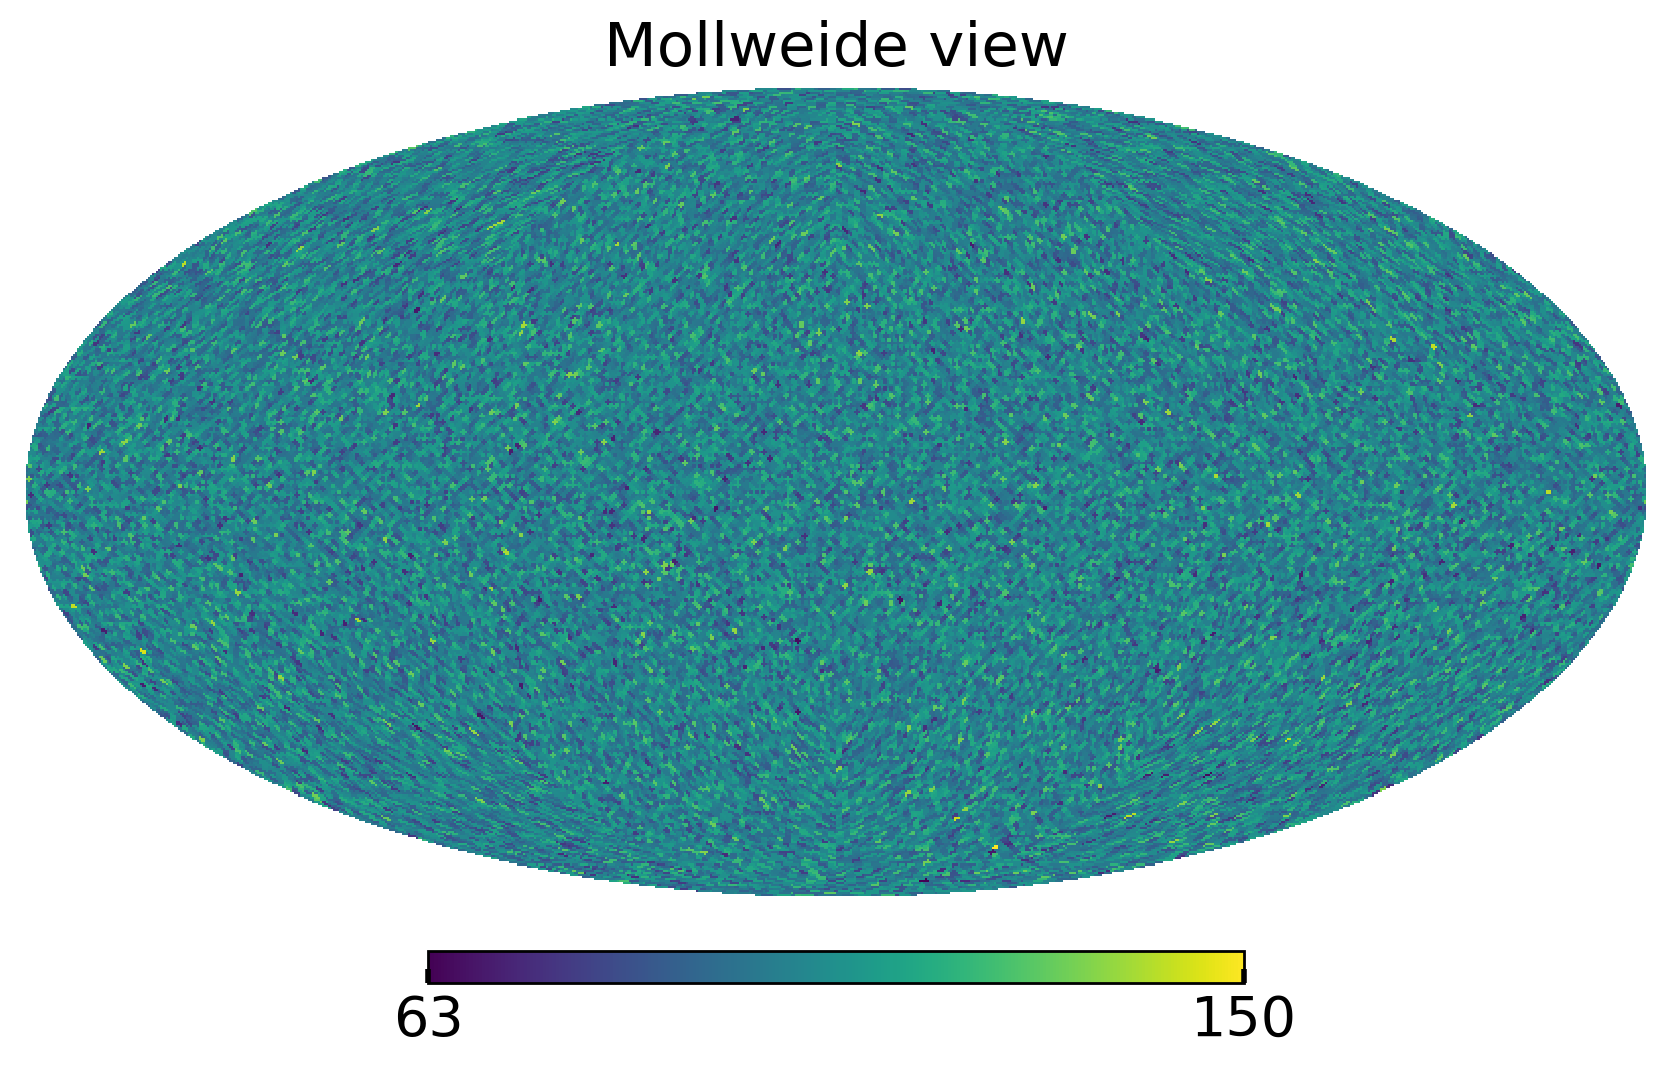

In [88]:
hm = makeHealpixMap(np.array(randoms['ra']), np.array(randoms['dec']),nside=64)
hp.mollview(hm)

In [89]:
hpx_coords = radec_to_pix(np.array(randoms['ra']), np.array(randoms['dec']),nside=64)
randoms['hpx_mask'] = hpxmap[hpx_coords].astype(bool)

In [90]:
des_footprint = randoms['hpx_mask']
randoms_des = randoms[des_footprint]
randoms_des

RandomCatalog(size=648834, seed=42)

optimizing parameters of Albers to minimize stdDistortion
best objective 0.047916 at Albers(22.285061564470745,-35.063914438467926,-57.80754330917929,-11.247384877083665)


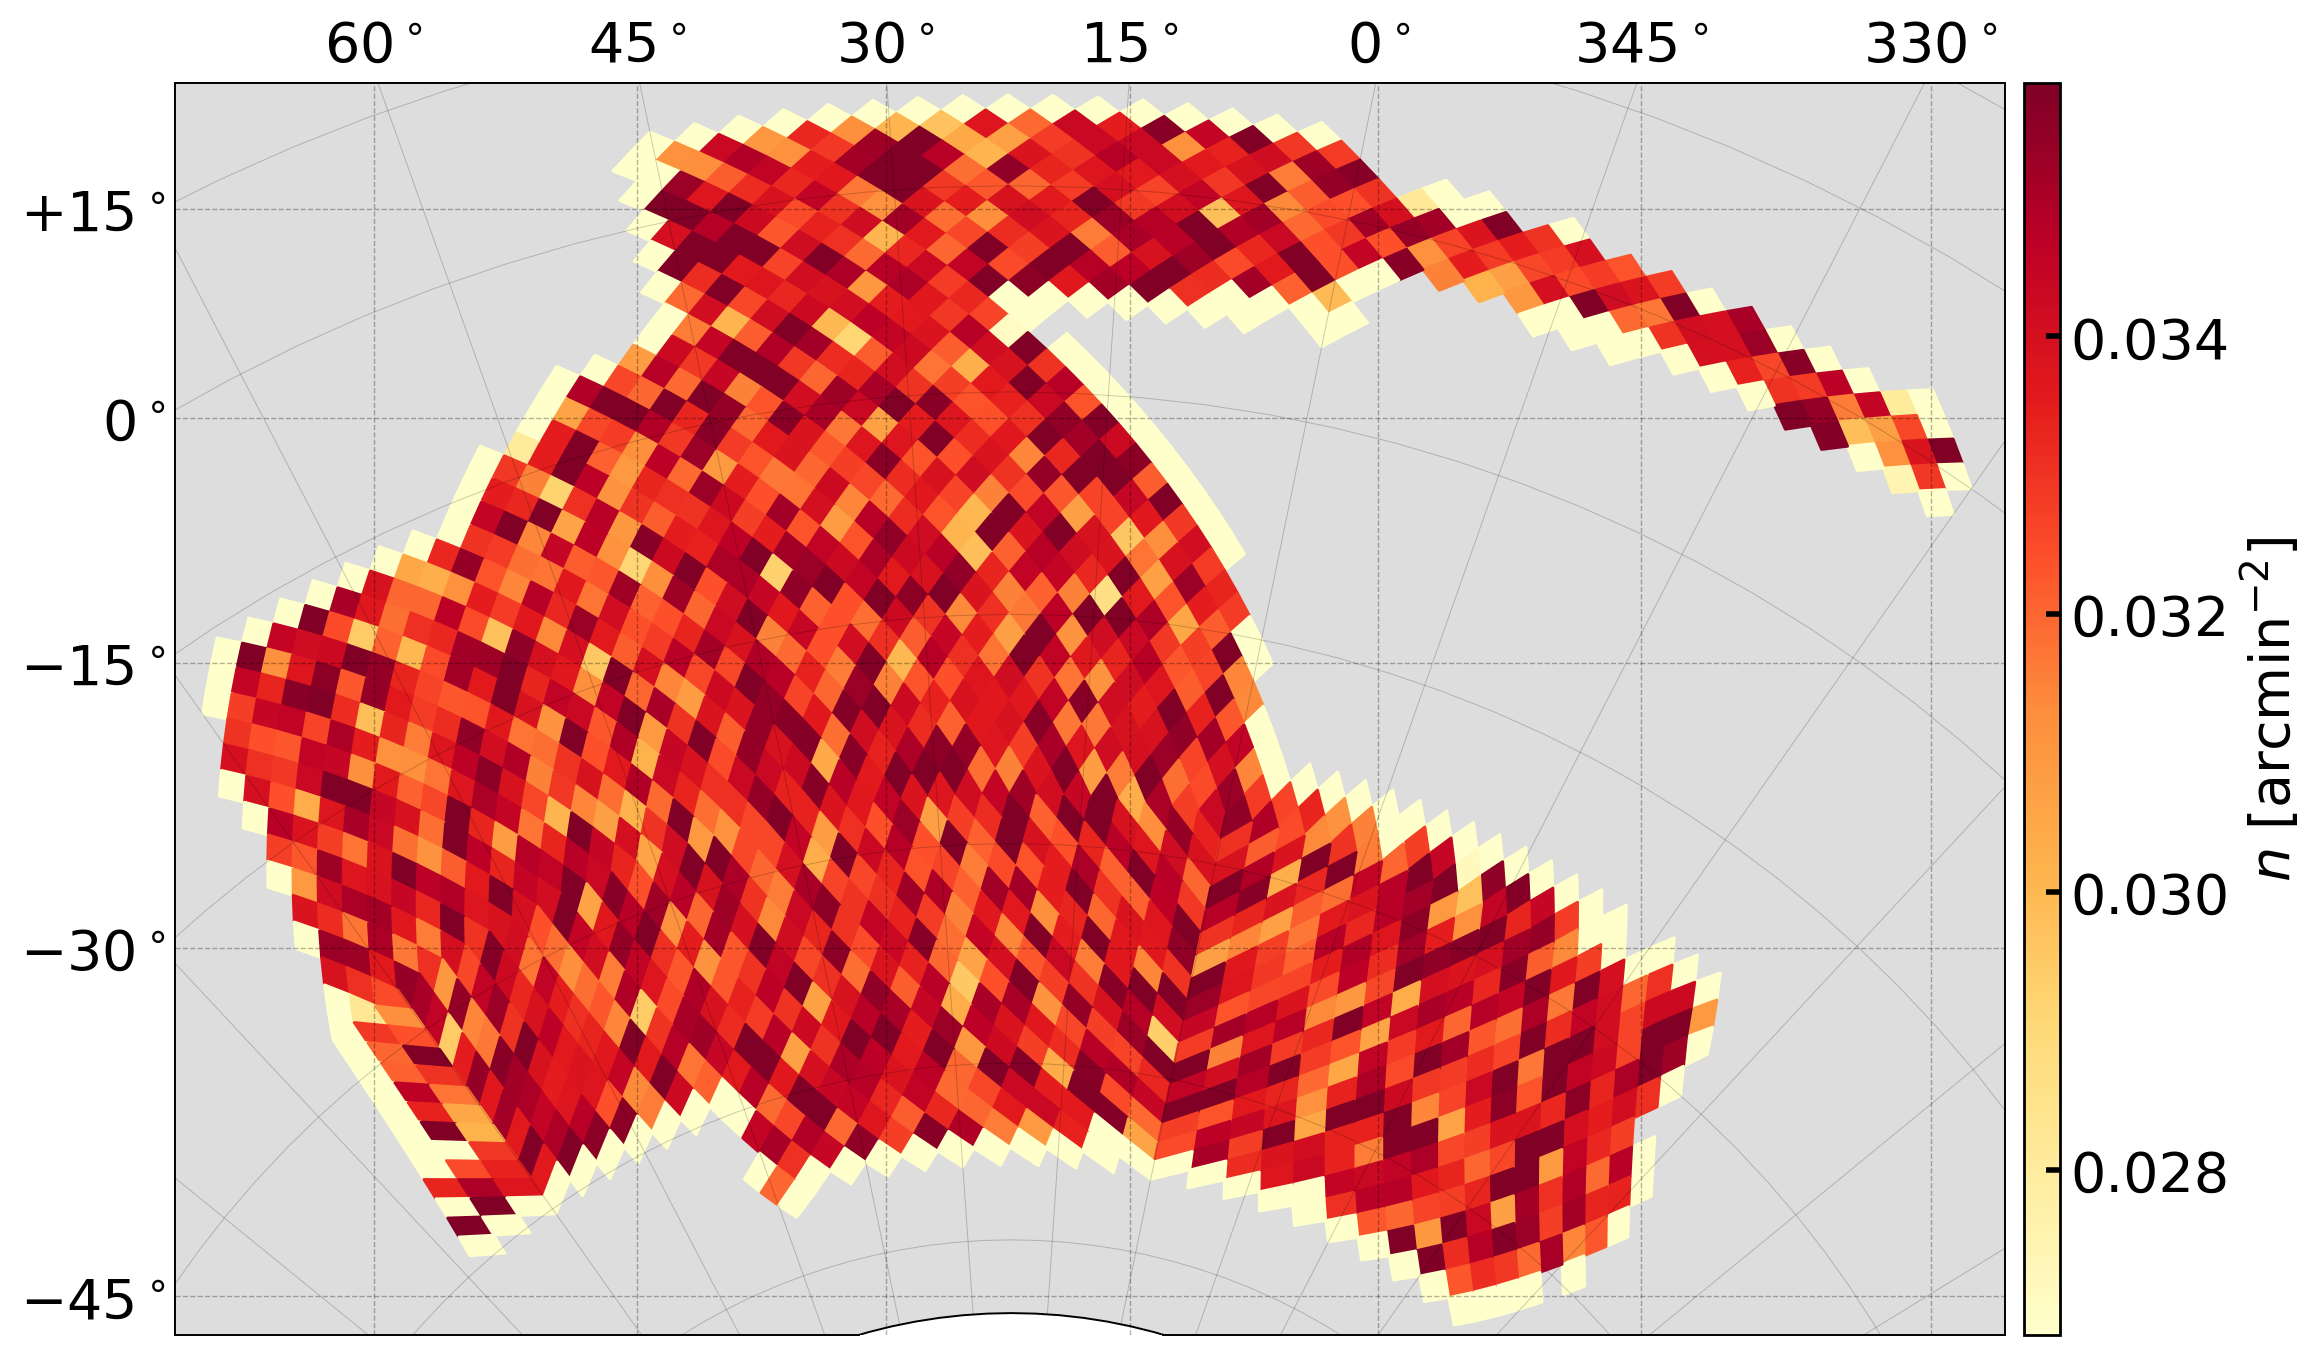

In [91]:
plot_hpx_density(np.array(randoms_des['ra']), np.array(randoms_des['dec']))


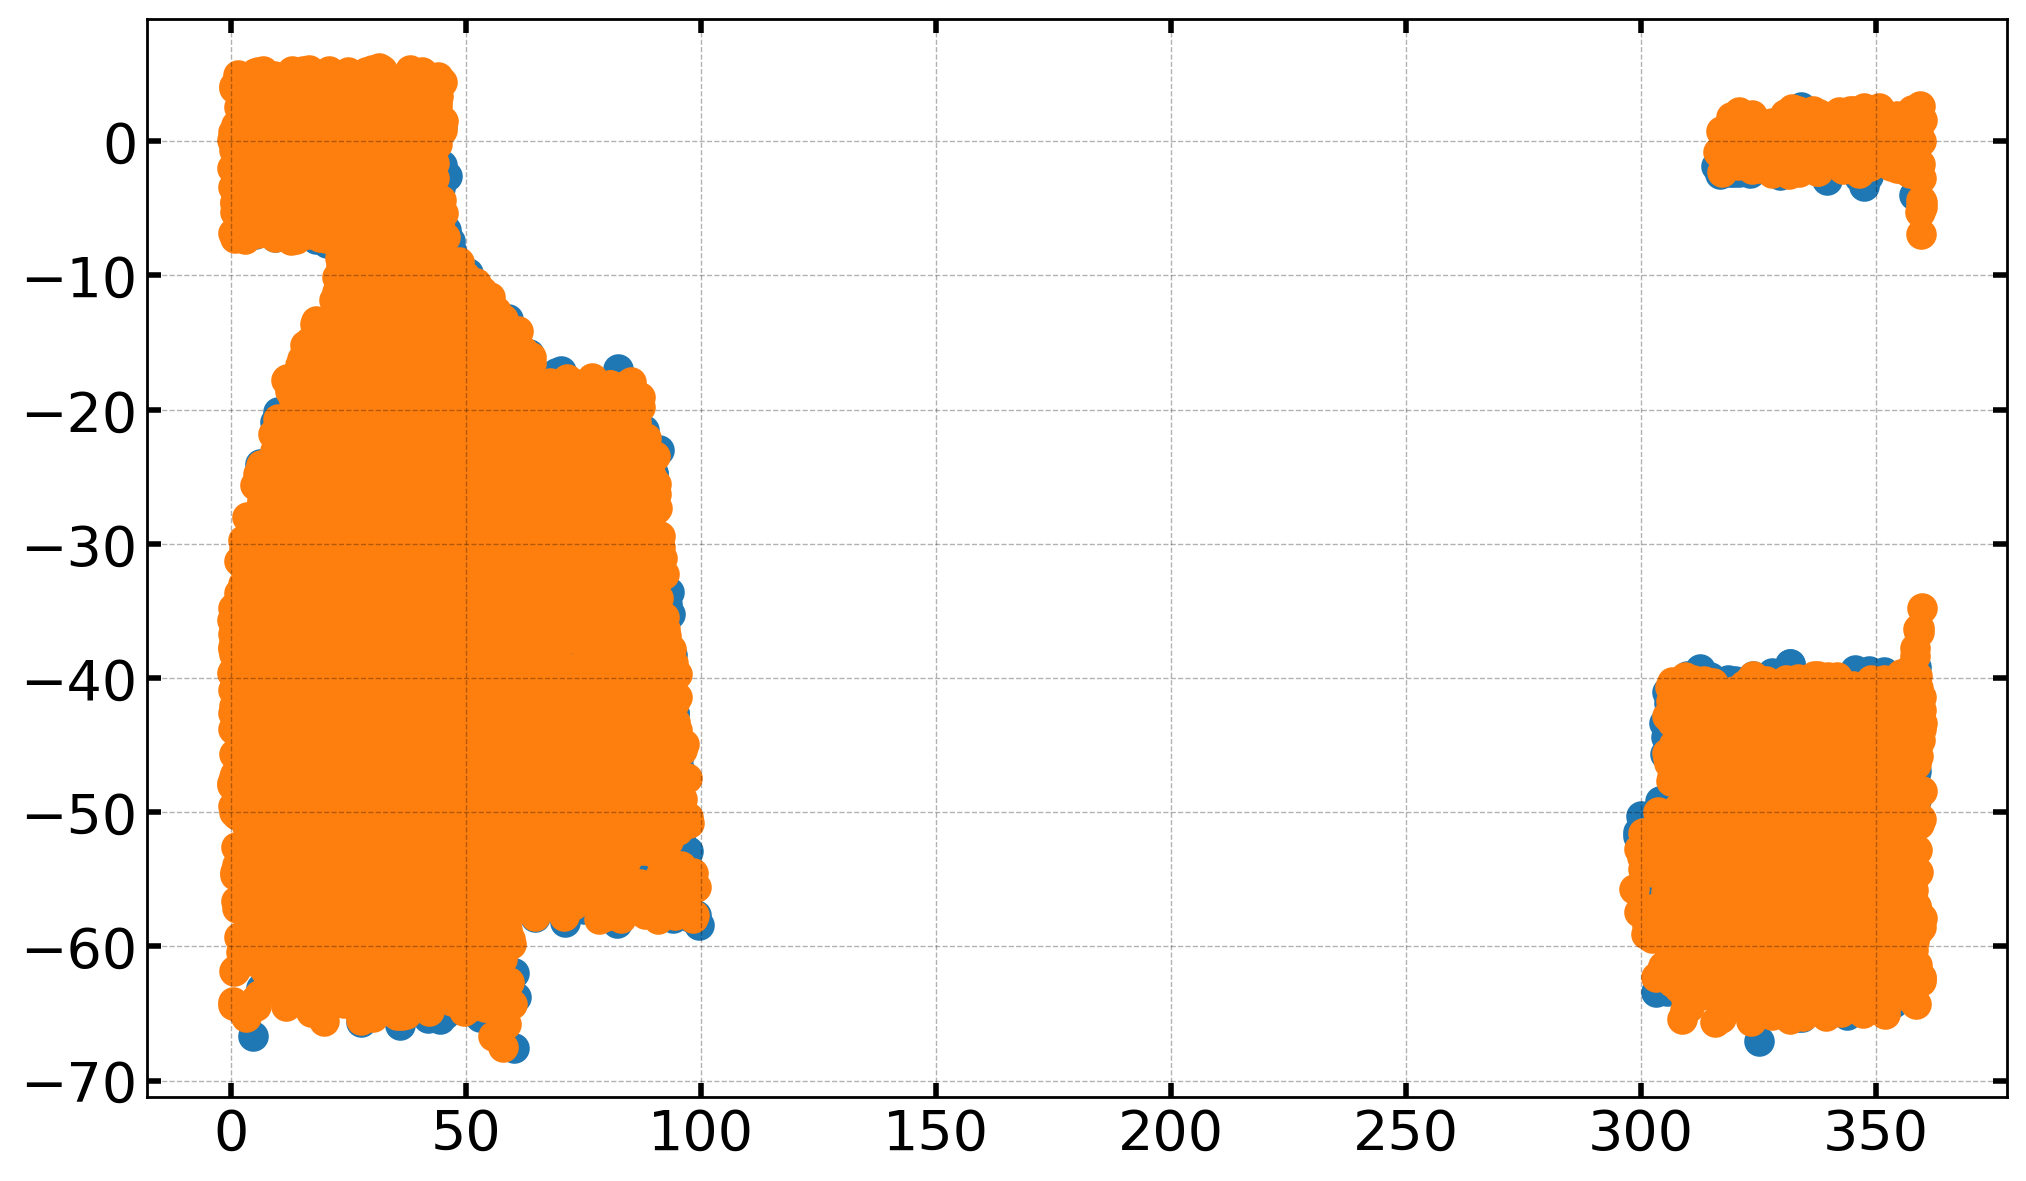

In [399]:
plt.scatter(np.array(randoms_des['ra'])[::100],np.array(randoms_des['dec'])[::100])
plt.scatter(np.array(data['ra'])[::100],np.array(data['dec'])[::100])

optimizing parameters of WagnerIV to minimize stdDistortion
best objective 0.095384 at WagnerIV(12.112329027816035)


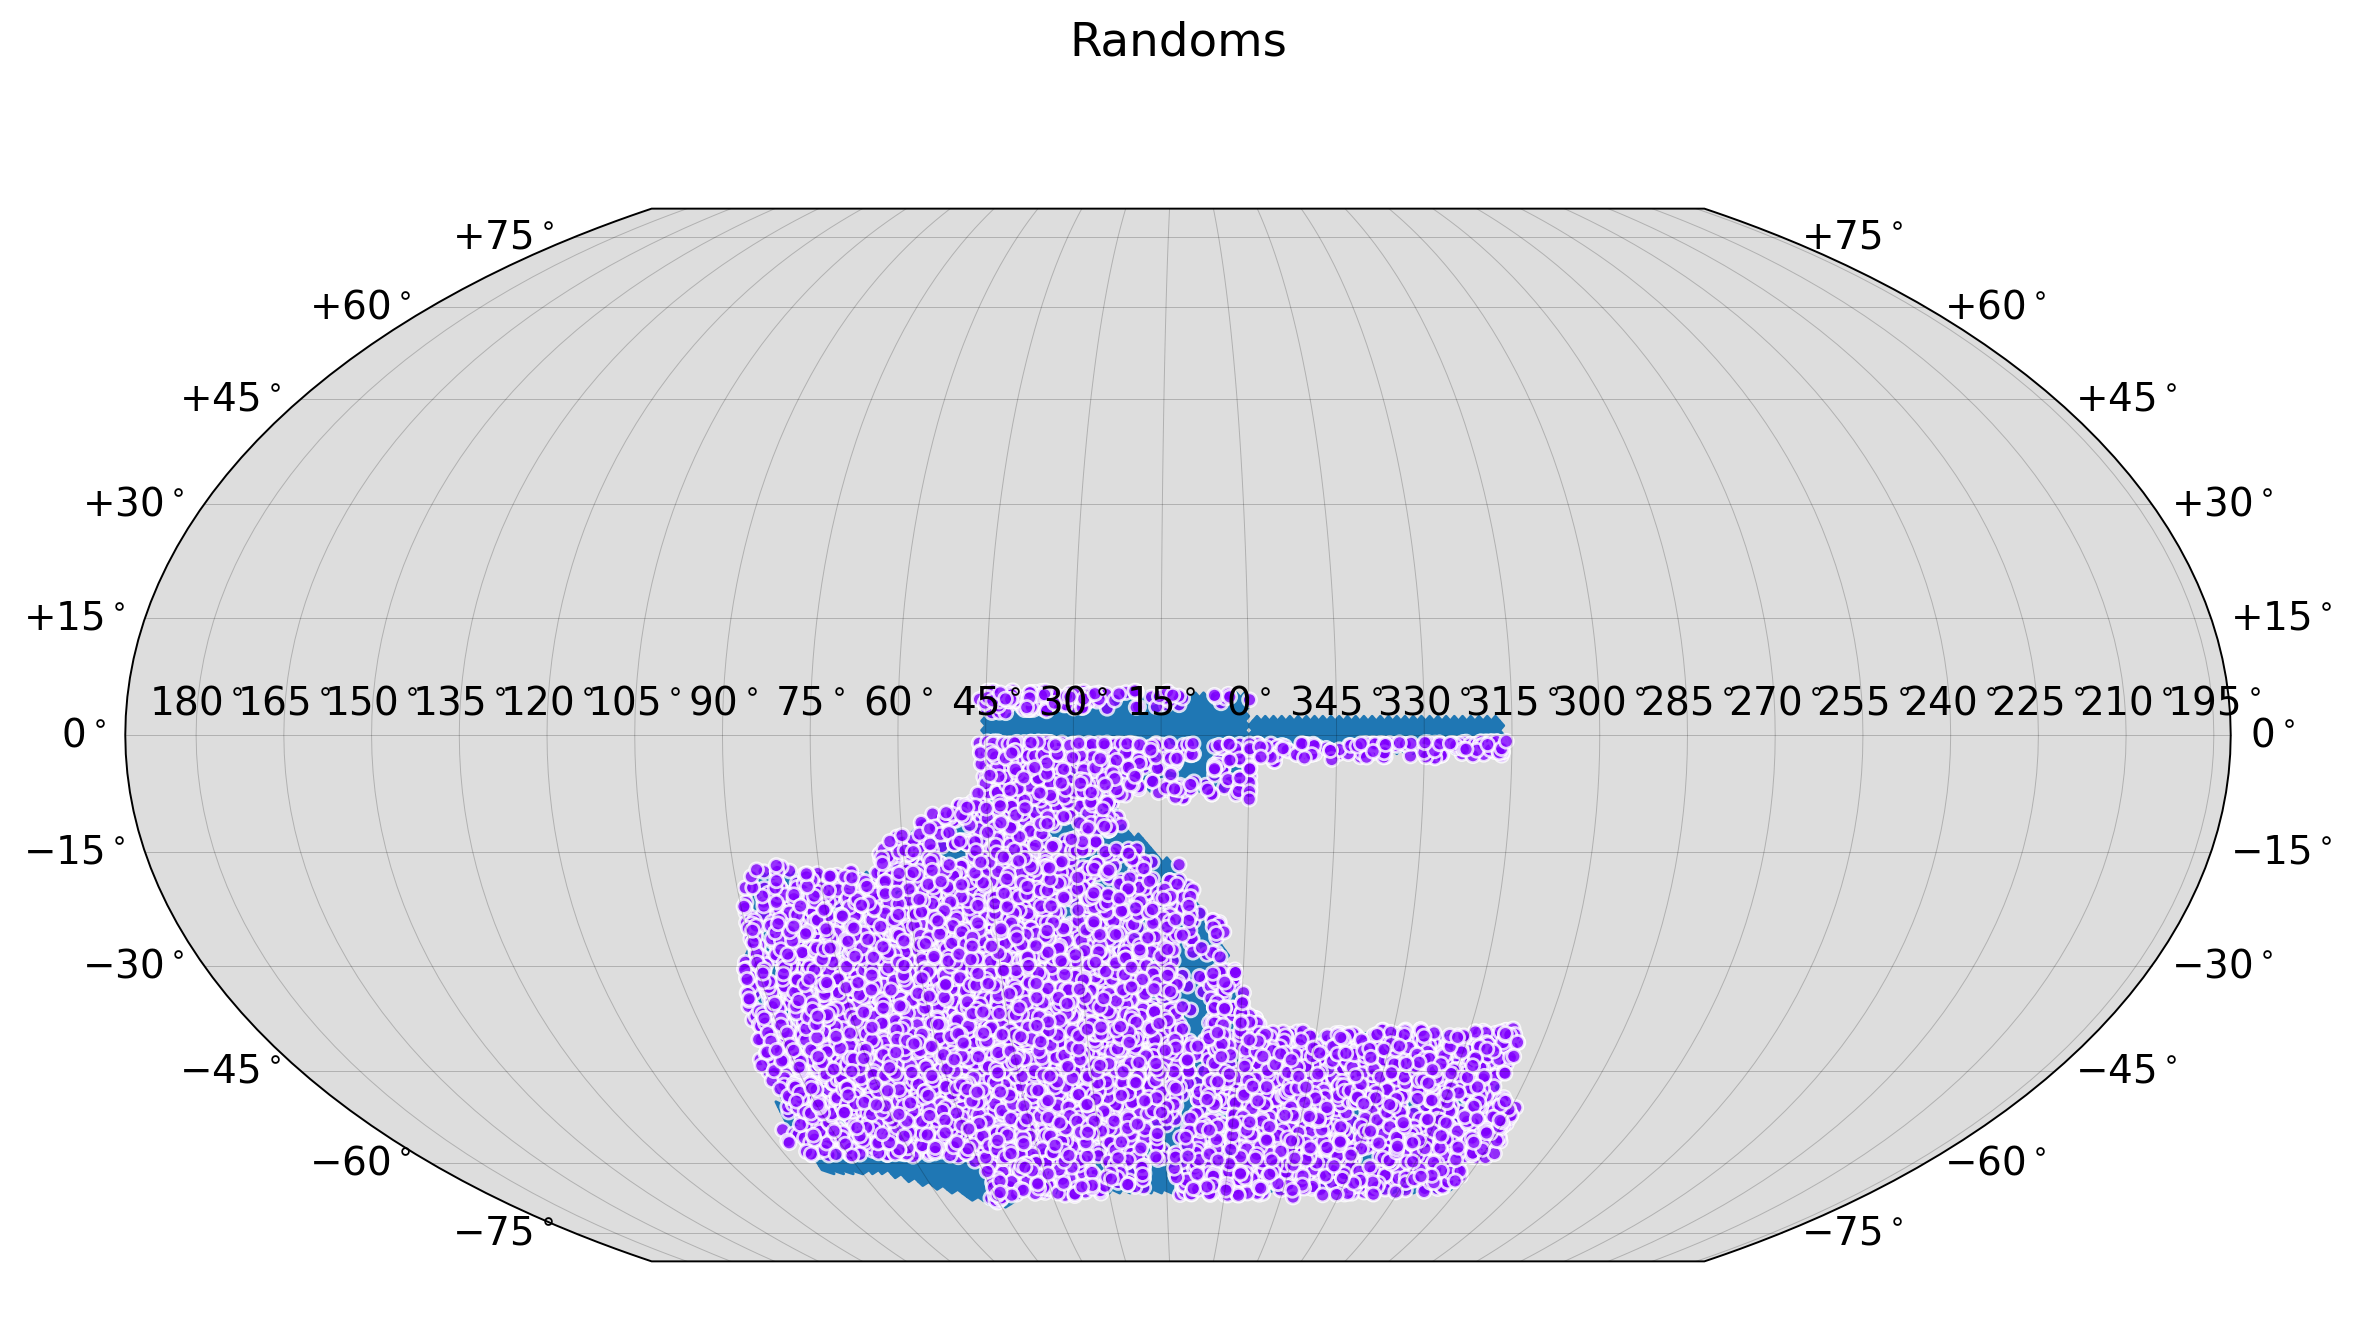

In [351]:
plot_proj(np.array(randoms_des['ra']), np.array(randoms_des['dec']), labels, title='Randoms')

In [ ]:
import healpy as hp
def radec_to_pix(ra,dec,nside=4):
    thetas,phis = np.radians(90-dec),np.radians(ra)
    return hp.ang2pix(nside, thetas, phis,nest=False)

In [ ]:
hpx_coords = radec_to_pix(np.array(combined['ra']), np.array(combined['dec']),nside=64)
combined['hpx_mask'] = hpxmap[hpx_coords].astype(bool)
desRan = combined[combined['hpx_mask']]

In [20]:
def plot_hpx_density(ra,dec, Npoints=10000):
    ix = np.random.randint(ra.size, size=Npoints)
    crit = skm.stdDistortion
    proj = skm.Albers.optimize(ra[ix], dec[ix], crit=crit)

    # construct map: will hold figure and projection
    # the outline of the sphere can be styled with kwargs for matplotlib Polygon
    map = skm.Map(proj)

    # add graticules, separated by 15 deg
    # the lines can be styled with kwargs for matplotlib Line2D
    # additional arguments for formatting the graticule labels
    sep=15
    map.grid(sep=sep)

    #### 1. plot density in healpix cells ####
    nside = 32
    mappable = map.density(ra, dec, nside=nside)
    cb = map.colorbar(mappable, cb_label="$n$ [arcmin$^{-2}$]")
    map.focus(ra[ix], dec[ix])
    
# example
# ra,dec = data['ra'],data['dec']
# plot_hpx_density(ra,dec)

In [ ]:
# print(source1.csize, source2.csize)

# source2['Position'] = source2['Position']
# combined = transform.ConcatenateSources(source1, source2, columns=['Position'])
# print(combined.csize)